In [1]:
Data_path = '../data_sets/PLAID/'
%pwd
%ls $Data_path

CSV/  debug/  meta1.json  test/  train/


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
csv_path = Data_path + 'CSV/'
csv_files = os.listdir(csv_path)

In [4]:

import subprocess

def read_data_given_id(path,ids,progress=False,last_offset=0):
    '''read data given a list of ids and CSV paths'''
    n = len(ids)
    if n == 0:
        return {}
    else:
        data = {}
        for (i,ist_id) in enumerate(ids, start=1):
            if progress:
                print('%d/%d is being read...'%(i,n))
            if last_offset==0:
                data[ist_id] = np.genfromtxt(path+str(ist_id)+'.csv',
                delimiter=',',names='current,voltage',dtype=(float,float))
            else:
                p=subprocess.Popen(['tail','-'+str(int(offset)),path+
                    str(ist_id)+'.csv'],stdout=subprocess.PIPE)
                data[ist_id] = np.genfromtxt(p.stdout,delimiter=',',
                    names='current,voltage',dtype=(float,float))
        return data



In [5]:
import json

with open(Data_path + 'meta1.json') as data_file:    
    meta1 = json.load(data_file)


meta = [meta1]
meta1[0]

{u'id': u'1',
 u'meta': {u'appliance': {u'brand': u'',
   u'current': u'',
   u'manufacture_year': u'',
   u'model_number': u'',
   u'notes': u'',
   u'voltage': u'',
   u'wattage': u''},
  u'header': {u'collection_time': u'July, 2013',
   u'notes': u'some instances are not well calibrated, meta data are not complete',
   u'sampling_frequency': u'30000Hz'},
  u'instances': {u'length': u'2.00s', u'status': u'off-on'},
  u'location': u'house1',
  u'type': u'Compact Fluorescent Lamp'}}

In [6]:
def clean_meta(ist):
    '''remove '' elements in Meta Data ''' 
    clean_ist = ist.copy()
    for k,v in ist.items():
#         if 
        if len(v) == 0:
            del clean_ist[k]
    return clean_ist
                
def parse_meta(meta):
    '''parse meta data for easy access'''
    M = {}
    for m in meta:
        for app in m:
            M[int(app['id'])] = clean_meta(app['meta'])
    return M
     
Meta = parse_meta(meta)    
Meta[1000]

{u'appliance': {u'brand': u'',
  u'current': u'',
  u'manufacture_year': u'',
  u'model_number': u'',
  u'notes': u'',
  u'voltage': u'',
  u'wattage': u''},
 u'header': {u'collection_time': u'July, 2013',
  u'notes': u'some instances are not well calibrated, meta data are not complete',
  u'sampling_frequency': u'30000Hz'},
 u'instances': {u'length': u'2.00s', u'status': u'off-on'},
 u'location': u'house51',
 u'type': u'Laptop'}

In [7]:
# applinace types of all instances
Types = [x['type'] for x in Meta.values()]
# unique appliance types
Unq_type = list(set(Types)) 
Unq_type.sort()
print(Unq_type)

# appliances
Apps = [x['meta']['type'] for x in meta1]

print('number of total instances: %d' % len(Types))
print('number of unique appliances: %d' % len(Apps))
print('number of unique appliance types: %d' % len(Unq_type))

[u'Air Conditioner', u'Compact Fluorescent Lamp', u'Fan', u'Fridge', u'Hairdryer', u'Heater', u'Incandescent Light Bulb', u'Laptop', u'Microwave', u'Vacuum', u'Washing Machine']
number of total instances: 1074
number of unique appliances: 1074
number of unique appliance types: 11


In [8]:
print('%25s\t%8s' % ('Appliance Type','# instances'))
for t in Unq_type:
    t_ids = [i for i,j in enumerate(Types) if j == t]
    print('%25s\t%10d' % (t,len(t_ids)))

           Appliance Type	# instances
          Air Conditioner	        66
 Compact Fluorescent Lamp	       175
                      Fan	       115
                   Fridge	        38
                Hairdryer	       156
                   Heater	        35
  Incandescent Light Bulb	       114
                   Laptop	       172
                Microwave	       139
                   Vacuum	        38
          Washing Machine	        26


In [9]:
# get 5 random instances from each type, will take ~ 1min to run
import random

count = 5
num_type = len(Unq_type)
fs = 30000

ids_to_draw = {}
t_data = {}
for (ii,t) in enumerate(Unq_type):
    t_ids = [i for i,j in enumerate(Types,start=1) if j == t]
    ids_to_draw[t] = random.sample(t_ids, count)
    t_data[t] = read_data_given_id(csv_path, ids_to_draw[t], False)


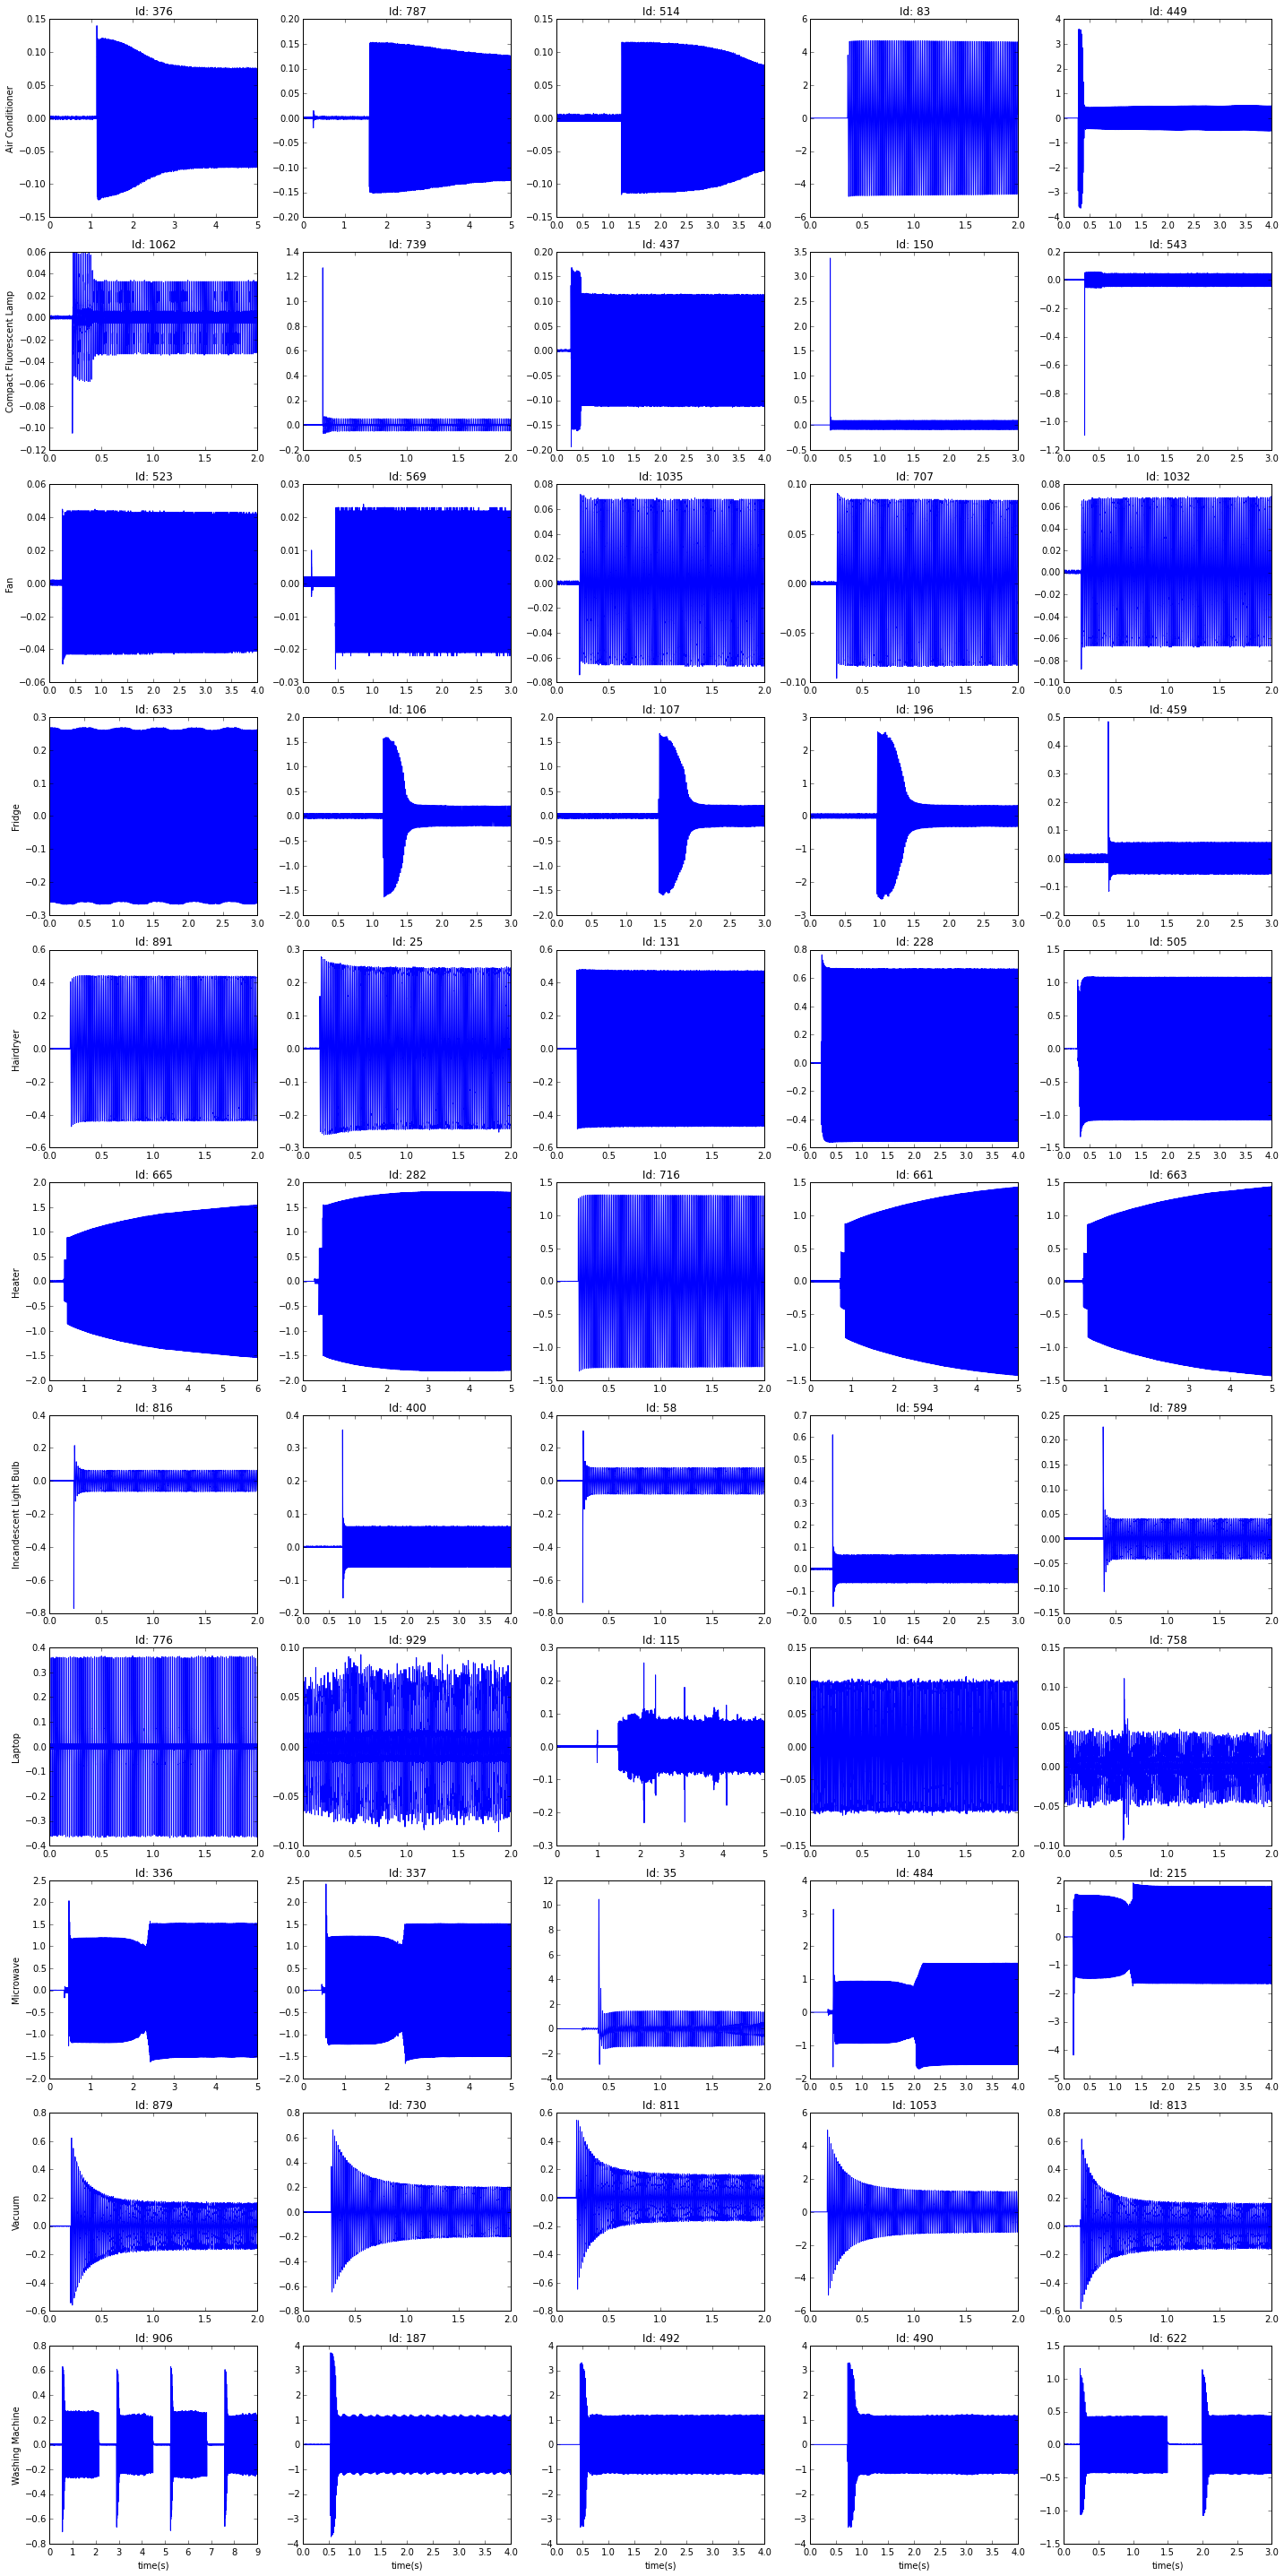

In [10]:
# plot current
fig = plt.figure(figsize=(20,40))
ids_to_draw = {}
for (ii,t) in enumerate(Unq_type):
    jj = 0
    for (k,v) in t_data[t].items():
        plt.subplot(num_type,count,ii*count+jj+1)
        plt.plot(np.linspace(1./fs,len(v['current'])/fs,num=len(v['current'])),v['current'])
        #plt.plot(np.linspace(1./fs,len(v['voltage'])/fs,num=len(v['voltage'])),v['voltage'])
        if ii==num_type-1:
            plt.xlabel('time(s)')
        if jj==0: 
            plt.ylabel(t,fontsize=10)
        plt.title('Id: '+str(k))
        jj += 1
fig.tight_layout()
plt.show()    


#Neural Net Part!

In [11]:
from pybrain.tools.shortcuts import buildNetwork
from pybrain.datasets import SupervisedDataSet
from pybrain.supervised.trainers import BackpropTrainer
import pandas as pd
numHidden = 3 #number of hidden layers
numOut = 1 # len(apps) * 2 (on/off?) - OneHotEncoding probably
onOffShiftParam = 10
onOffWindowSize = 2000
onOffShiftSize = onOffWindowSize / onOffShiftParam
nnWindowSize = 30000 #how many time steps are we looking at. parsing works well at 1-2k inputs and 100-200 for shift
nnShiftSize = nnWindowSize / onOffShiftParam
numOffZeros = 10000
translateParam = 0.1

In [186]:
def addOffSequence(data):
    return np.append(data, np.zeros(numOffZeros, dtype=data.dtype))
def addOnSequence(data):
    return [o for o in np.append(np.zeros(numOffZeros, dtype=data.dtype), data) if o!=None]

def toHybridWindows(data, shiftSize, windowSize):
    for r in range(0, len(data) / shiftSize):
            yield data[r*shiftSize:windowSize + r*shiftSize]
            
def parseOutputs(windows):
    FP_THRESH = np.mean(windows, axis=0)
    diffs = []
    #Might look something like "if kpss(window) > PARAMETER: ouput = 1, else ...
    #Or something simple like (window[i] - window[i-1] / window[i] > PARAMETER then output = 1...)
    # The simple way is called the First Difference of the series
    for i, _ in enumerate(windows):
        if i > 0:
            window = np.mean(windows[i])
            past =  np.mean(windows[i-1])
            if abs(window - past) < abs(FP_THRESH[i]):
                mean_diff = 0.0
            else:
                mean_diff = window - past
            diffs.append(mean_diff)
        else:
            diffs.append(0.0)
    return diffs

Okay so we want to determine whether or not the series is stable, and label the windows appropriately for on/offs.

* Choice: Overlapping windows or distinct windows -> Hybrid
* Choice: What kind of measure should we use for staionarity?
    * Right now I'm just using the first difference method but is there a better way I should be using?
* Choice: Threshold variable for "stationary"
* Choice: Append zeroes to front and back of each signal for off signalling? Some signals don't have zeroes at the end, is that okay to leave without an off signal or should we train on something that just drops to zero without warning? (Probably \#2, should check though)

In [187]:
def windowToTotal(windows):
    global onOffShiftParam, onOffWindowSize
    tempOuts = []
    for i, window in enumerate(windows):
        if i % onOffShiftParam == 0:
            tempOuts.extend([window] * onOffWindowSize)
    return tempOuts

def parseBinOutputs(window_outputs):
    sig_start = 2.5
    sig_end = 4.0
    outMean = np.mean(window_outputs)
    outStd = np.std(window_outputs)
    numStds = 1.8
    maxStartLength = len(window_outputs) / 5
    maxEndLength = len(window_outputs) / 10
    
    out = [o if abs(o - outMean) > outMean + outStd*numStds else 0 for o in window_outputs ]
    starts = filter(lambda pair: pair[1] != 0, [(i,1) if o != 0 and i < int(len(out) / sig_start) else (i,0) for i, o in enumerate(out)])
    ends = filter(lambda pair: pair[1] != 0, [(i,-1) if o != 0 and i > len(out) - int(len(out) / sig_end) else (i,0) for i, o in enumerate(out)])
    
    if starts:
        first_start = starts[0][0]
        last_start = starts[-1][0]
        if last_start - first_start > maxStartLength:
            print "start length"
            last_start = first_start + maxStartLength
    else:
        first_start = -1
        last_start = -1
    if ends:
        first_end = ends[0][0]
        last_end = ends[-1][0]
        if last_end - first_end > maxEndLength:
            print "end length"
            last_end = first_end + maxEndLength
    else:
        first_end = -1
        last_end = -1
    
    firstOff = windowToTotal(window_outputs[:first_start])
    turningOn = windowToTotal(window_outputs[first_start:last_start])
    running = windowToTotal(window_outputs[last_start:first_end])
    turningOff = windowToTotal(window_outputs[first_end:last_end])
    finalOff = windowToTotal(window_outputs[last_end:])
    
    return firstOff, turningOn, running, turningOff, finalOff

It looks like the mean diff method has a difficult time with sinusoidal signals. Also, because the signals have different frequency domains, using a single window size for all of them is difficult.

Okay!

* At this point we have some reasonably clean transition signals to go by.


* Our algorithm for marking needs to keep track of whether or not it's turned something on or off and it should only do each once for any given series. The "off" signal should come at the end of a signal, after a number of zeroes have been appended (probably 10,000). 

* Heuristically, the data I'm seeing looks like most signals have an on transition, with some starting noise in the signal, stabalize, then we turn them off abruptly. 
    * One way to turn this into a good input sequence is to set all time slots from START to END OF START as 1 (going forwards), and all signals from END to START OF END SEQUENCE to -1. 0's elsewhere
    * This strategy has a few pitfalls:
        * Any signals that turn on and off more than once during the time (or are cyclic) will be misread / trained. I'm not sure how to fix this.
        * Many signals go through a strong on phase, followed by a weaker but still existent "stabalize" phase, and we want to train the signal that for any sequence between and including those phases the appliance is turning on. 
* Let's try guessing that the signal portion within the first 1/3 of the signal duration between the first sign of "on" and the last sign of "stabilizing" will be "turning on"
     * Similar for off. Last ~12,000 turns anything with high variability will be "turning off"



In [188]:
def parseIntoSingleCycle(data):
    outMean = np.mean(data)
    outStd = np.std(data)
    cutoff = outStd
    
    print outMean
    print outStd
    print cutoff
    out = [o if abs(o - outMean) > cutoff else 0 for o in data ]
    #out_from_mean = [(i,abs(o - outMean)) for i, o in enumerate(out) ]
    #out_from_mean2 = [abs(o - outMean) for i, o in enumerate(out) ]
    
    foundCycle = False
    startCycle = -1
    endCycle = -1
    onTolerance = 0.0001
    offTolerance = 0.0000001
    window = 1000
    for i, _ in enumerate(out):
        if i < window:
            continue
        if i % window == 0:
            mv_av = np.mean(map(abs,out[i-window:i]))
            #print mv_av
            if (not foundCycle) and mv_av > onTolerance:
                foundCycle = True
                startCycle = i-wi
            if foundCycle and mv_av <= offTolerance:
                endCycle = i
                break
    print "startCycle = " + str(startCycle)
    print "endCycle = " + str(endCycle)
    if startCycle != -1 and endCycle == -1:
        singleCycle = data[startCycle:]
    elif startCycle != -1 and endCycle != -1:
        singleCycle = data[startCycle:endCycle]
    else:
        print "Error finding singleCycle"
        singleCycle = data
    return out, singleCycle

906
0.000441380434783
0.153257958296
0.153257958296
startCycle = 18000
endCycle = 67000


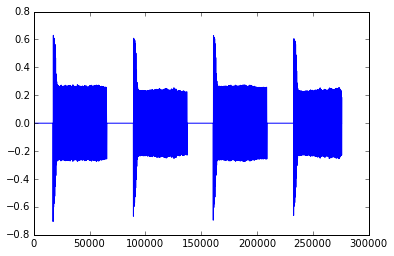

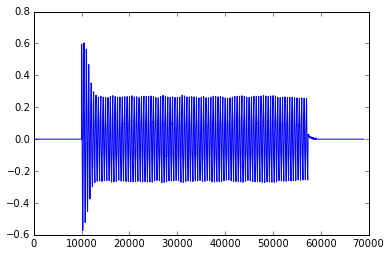

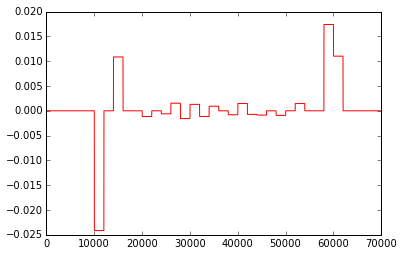

187
0.000988142857143
0.805890300347
0.805890300347
startCycle = 17000
endCycle = -1


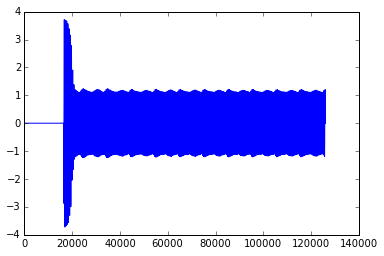

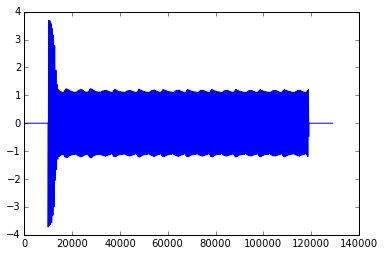

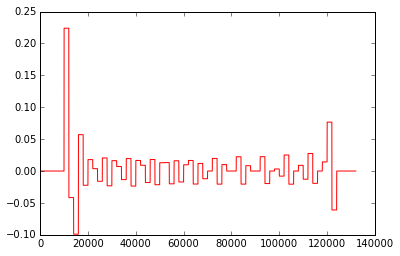

492
0.000733722627737
0.842889331932
0.842889331932
startCycle = 16000
endCycle = -1


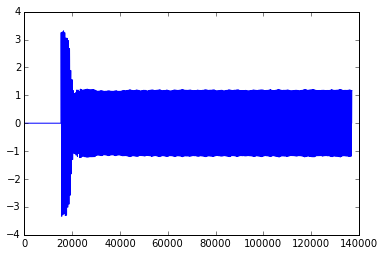

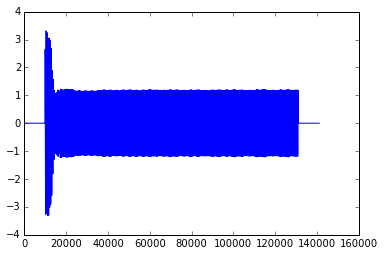

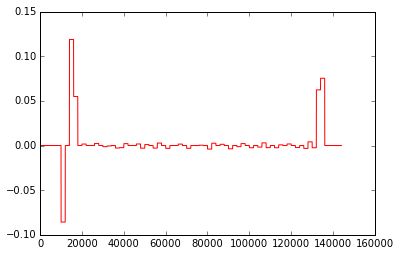

490
0.00137221428571
0.825651984373
0.825651984373
startCycle = 26000
endCycle = -1


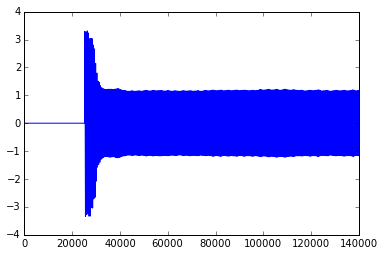

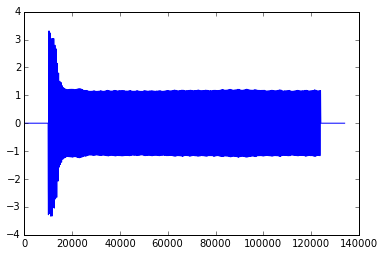

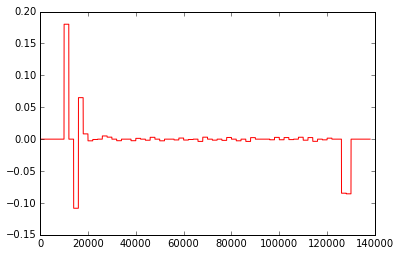

622
0.000462222222222
0.262454220803
0.262454220803
startCycle = 9000
endCycle = 55000


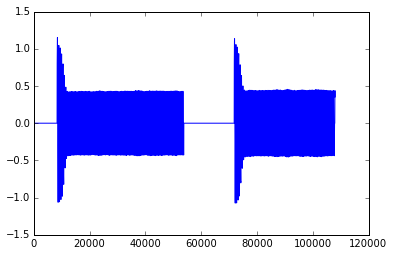

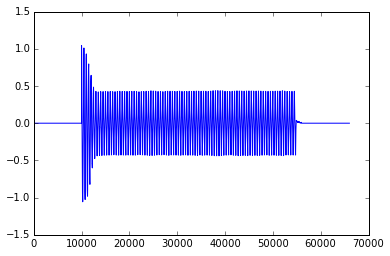

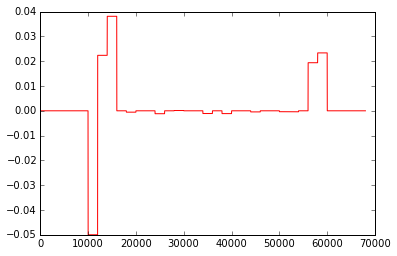

In [192]:
#for (ii,t) in enumerate(Unq_type):
for (k,df_v) in t_data[t].items():
    print k
    v = df_v['current']
    out, v = parseIntoSingleCycle(v)
    v = addOnSequence(addOffSequence(v))
    window_inputs = pd.DataFrame([item for item in toHybridWindows(v, onOffShiftSize, onOffWindowSize) if len(item) == onOffWindowSize]).transpose()
    window_outputs = parseOutputs(window_inputs)
    firstOff, turningOn, running, turningOff, finalOff = parseBinOutputs(window_outputs)
    #form each window into feature vectors
    
    #label output vector for corresponding feature vector
    
    #store in data set
    #plt.plot(v)
    #plt.plot(v)
    plt.plot(out)
    plt.show()
    plt.plot(v)
    plt.show()
    plt.plot(firstOff + turningOn + running + turningOff + finalOff, color="red")
    plt.show()

Cool! It works! So now we have pretty good signal identification for on/off on nicely formatted signals that only turn on and off once.

The NN will train on window_inputs and bin_outputs, after we transform bin_outputs using the metadata to correctly encode it for what type of appliance it was running. 

* Note: We'll need to do some (more) pre-processing on signals to cut them down to a single on/off cycle for training but I'm gonna press forward for now since most are well formed.

In [ ]:
#print trainer.train()

In [ ]:

def test(training_ds):
    global net
    lst = []
    for training in training_ds:
        lst.append(net.activate(training))
    return lst
#test_ans = pd.Series(test(nnInputs.tolist()))

In [ ]:
#print test_ans

To resolve between appliance types and within appliance types we might want to use a different type of signal windowing. [here](https://en.wikipedia.org/wiki/Spectral_leakage) Extra features then?

Might work to just take the top 10 or so frequencies from  FFT and just run on that? Looks like different signals have different frequency distributions. 

Also taking the mean amplitudes of things into account (heater vs lightbulb)

Learn more about features from [here](https://dsp.stackexchange.com/questions/16870/feature-extraction-from-spectrum-to-aid-categorisation/16873#16873). Looks like a really useful list of things to account for, in addition to major frequencies.

In [ ]:
print 1